In [ ]:
# Parameters
data_root = "/home/user/HumanActivityRecognitionEfficiencyEstimation"
date_time = "7-9-24"
field = "SantaMaria_2024"


## Classification of Season-long Data for Pick and NoPick Activities

In [ ]:
#general imports
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # just changing to CPU based inferencing
import tensorflow as tf
from sklearn.preprocessing import RobustScaler


#project related imports
import utils.dataFileRead as file_reader #util for reading data files
import utils.dataFiltering as data_filter # util for filtering data
from yieldnn2025 import YieldNN  # yieldnn for pick no pick classificaton


plt.rcParams['figure.figsize'] = [20, 10]
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
tf.get_logger().setLevel('ERROR')

2025-07-14 15:11:03.139785: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 15:11:03.149524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-14 15:11:03.160473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-14 15:11:03.163746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 15:11:03.171716: I tensorflow/core/platform/cpu_feature_guar

2025-07-14 15:11:03.651873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# field specific parameters
save_results=True
# field=="SantaMaria"
root_dir=data_root
data_folder=os.path.join(data_root,"datasets",field)
model_path=os.path.join("weights","mass_imu_0210-1657.keras")


map_path="./field_maps/SantaMaria2024.txt"
num_rows=127
max_velx=0.45
max_vely=0.5
field_bound_miny=0
field_bound_maxy=191.5
field_bound_minx=-203
field_bound_maxx=1


## Load map file from text file
Get the transformed map data from latitutde longitude to field coordinates

In [4]:
# Loding the map data
map_data = data_filter.load_map(map_path)
odom_NDs = map_data['odom_NDs']
odom_FDs = map_data['odom_FDs']
utm_NDs = map_data['utm_NDs']
utm_FDs = map_data['utm_FDs']
llh_NDs = map_data['llh_NDs'] 
llh_FDs = map_data['llh_FDs']
odom_T_utm = map_data['odom_T_utm']

In [5]:
# Estimation of field related parameters
furrow_centerx = (odom_NDs[:,0][:-1]+odom_NDs[:,0][1:])/2.0 
row_width = np.abs(np.diff(odom_NDs[:,0])).mean() #furrow to furrow width
row_xs = (odom_NDs[:,0][:-1]+odom_NDs[:,0][1:])/2.0
row_ys=np.vstack((odom_NDs[:,1],odom_FDs[:,1])).T

In [6]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#1a55FF', '#ff3311', '#32CD32', '#FF69B4', '#8B008B',
          '#00FFFF', '#FFD700', '#FF00FF', '#4B0082', '#FF6347',
          '#00FF7F', '#DC143C', "#16A8AA", '#FF4500', '#DA70D6',
          '#32CD32', '#FF69B4', '#87CEEB', '#DDA0DD', '#F0E68C']
def plot_beds():
    """
    Plots the field beds using odometry data.
    """
    plt.rcParams['figure.figsize'] = [70, 20]
    i = 0
    for ND_odom, FD_odom in zip(odom_NDs, odom_FDs):
        xs = [ND_odom[0], FD_odom[0]]
        ys = [ND_odom[1], FD_odom[1]]
        if i < num_rows:  # this value needs to be dynamic and based on the odom_NDs
            if i % 2 == 0:
                plt.text(xs[0] - 1.2, ys[0] + 1, str(i), fontsize=17)
            else:
                plt.text(xs[1] - 1.2, ys[1] - 1, str(i), fontsize=17)

        plt.plot(xs, ys, "*-", c='g')

        i += 1

# plot_beds()

### Read CSV, select required data columns, add easting and northing coordinates

- **Input Header**:  
    `rpi_utc_time`, `gps_utc_time`, `GPS_TOW`, `LAT`, `LON`, `HEIGHT`, `ax`, `ay`, `az`, `raw_mass`

- **Output Header**:  
    `GPS_TOW`, `LAT`, `LON`, `HEIGHT`, `ax`, `ay`, `az`, `raw_mass`, `easting`, `northing`

In [ ]:
print(f"Reading data from {os.path.join(data_folder,date_time)}")
raw_data=file_reader.read_files(os.path.join(data_folder,date_time))

Reading data from /media/uddhav/My_Passport/00_STAVROS_LAB/Harvest_2024/datasets/SantaMaria/7-9-24
*****converting cart1.csv into numpy array****


(206349, 8)


(206349, 10)
************************************
*****converting cart10.csv into numpy array****


(181588, 8)


(181588, 10)
************************************
*****converting cart11.csv into numpy array****


(203353, 8)


(203353, 10)
************************************
*****converting cart13.csv into numpy array****


(207248, 8)


(207248, 10)
************************************
*****converting cart16.csv into numpy array****


(205649, 8)


(205649, 10)
************************************
*****converting cart2.csv into numpy array****


(206923, 8)


(206923, 10)
************************************
*****converting cart21.csv into numpy array****


(206700, 8)


latitude out of range (must be between 80 deg S and 84 deg N)
error line:  [nan, nan, nan, nan, nan, nan, nan, nan]
(206699, 10)
************************************
*****converting cart25.csv into numpy array****


(206899, 8)


(206899, 10)
************************************
*****converting cart26.csv into numpy array****


(206399, 8)


(206399, 10)
************************************
*****converting cart30.csv into numpy array****


(206600, 8)


latitude out of range (must be between 80 deg S and 84 deg N)
error line:  [nan, nan, nan, nan, nan, nan, nan, nan]
(206599, 10)
************************************
*****converting cart32.csv into numpy array****


(202299, 8)


(202299, 10)
************************************
*****converting cart38.csv into numpy array****


(207249, 8)


(207249, 10)
************************************
*****converting cart4.csv into numpy array****


(206899, 8)


(206899, 10)
************************************
*****converting cart56.csv into numpy array****


(127348, 8)


(127348, 10)
************************************
*****converting cart59.csv into numpy array****


(206700, 8)


latitude out of range (must be between 80 deg S and 84 deg N)
error line:  [nan, nan, nan, nan, nan, nan, nan, nan]
(206699, 10)
************************************
*****converting cart6.csv into numpy array****


(203700, 8)


latitude out of range (must be between 80 deg S and 84 deg N)
error line:  [nan, nan, nan, nan, nan, nan, nan, nan]
(203699, 10)
************************************
*****converting cart60.csv into numpy array****


(204948, 8)


(204948, 10)
************************************
*****converting cart62.csv into numpy array****


(195949, 8)


(195949, 10)
************************************
*****converting cart63.csv into numpy array****


(207249, 8)


(207249, 10)
************************************
*****converting cart67.csv into numpy array****


(171949, 8)


(171949, 10)
************************************
*****converting cart68.csv into numpy array****


(206899, 8)


(206899, 10)
************************************
*****converting cart69.csv into numpy array****


(206349, 8)


(206349, 10)
************************************
*****converting cart70.csv into numpy array****


(201396, 8)


(201396, 10)
************************************
*****converting cart73.csv into numpy array****


(206349, 8)


(206349, 10)
************************************
*****converting cart75.csv into numpy array****


(201813, 8)


(201813, 10)
************************************
*****converting cart76.csv into numpy array****


(175703, 8)


(175703, 10)
************************************
*****converting cart77.csv into numpy array****


(204649, 8)


(204649, 10)
************************************
*****converting cart80.csv into numpy array****


(207249, 8)


(207249, 10)
************************************


### Transform the GPS easting and northing coordinates to field coordinates

- **Input Header**:  
    `GPS_TOW`, `LAT`, `LON`, `HEIGHT`, `ax`, `ay`, `az`, `raw_mass`, `easting`, `northing`

- **Output Header**:  
    `GPS_TOW`, `LAT`, `LON`, `HEIGHT`, `ax`, `ay`, `az`, `raw_mass`, `easting`, `northing`, `x`, `y`

In [8]:
raw_field_data=data_filter.augment_field_coords(raw_data, odom_T_utm) 
print("Number of carts: ",len(raw_field_data.keys()))

Number of carts:  28


Text(0.5, 1.0, 'Raw data')

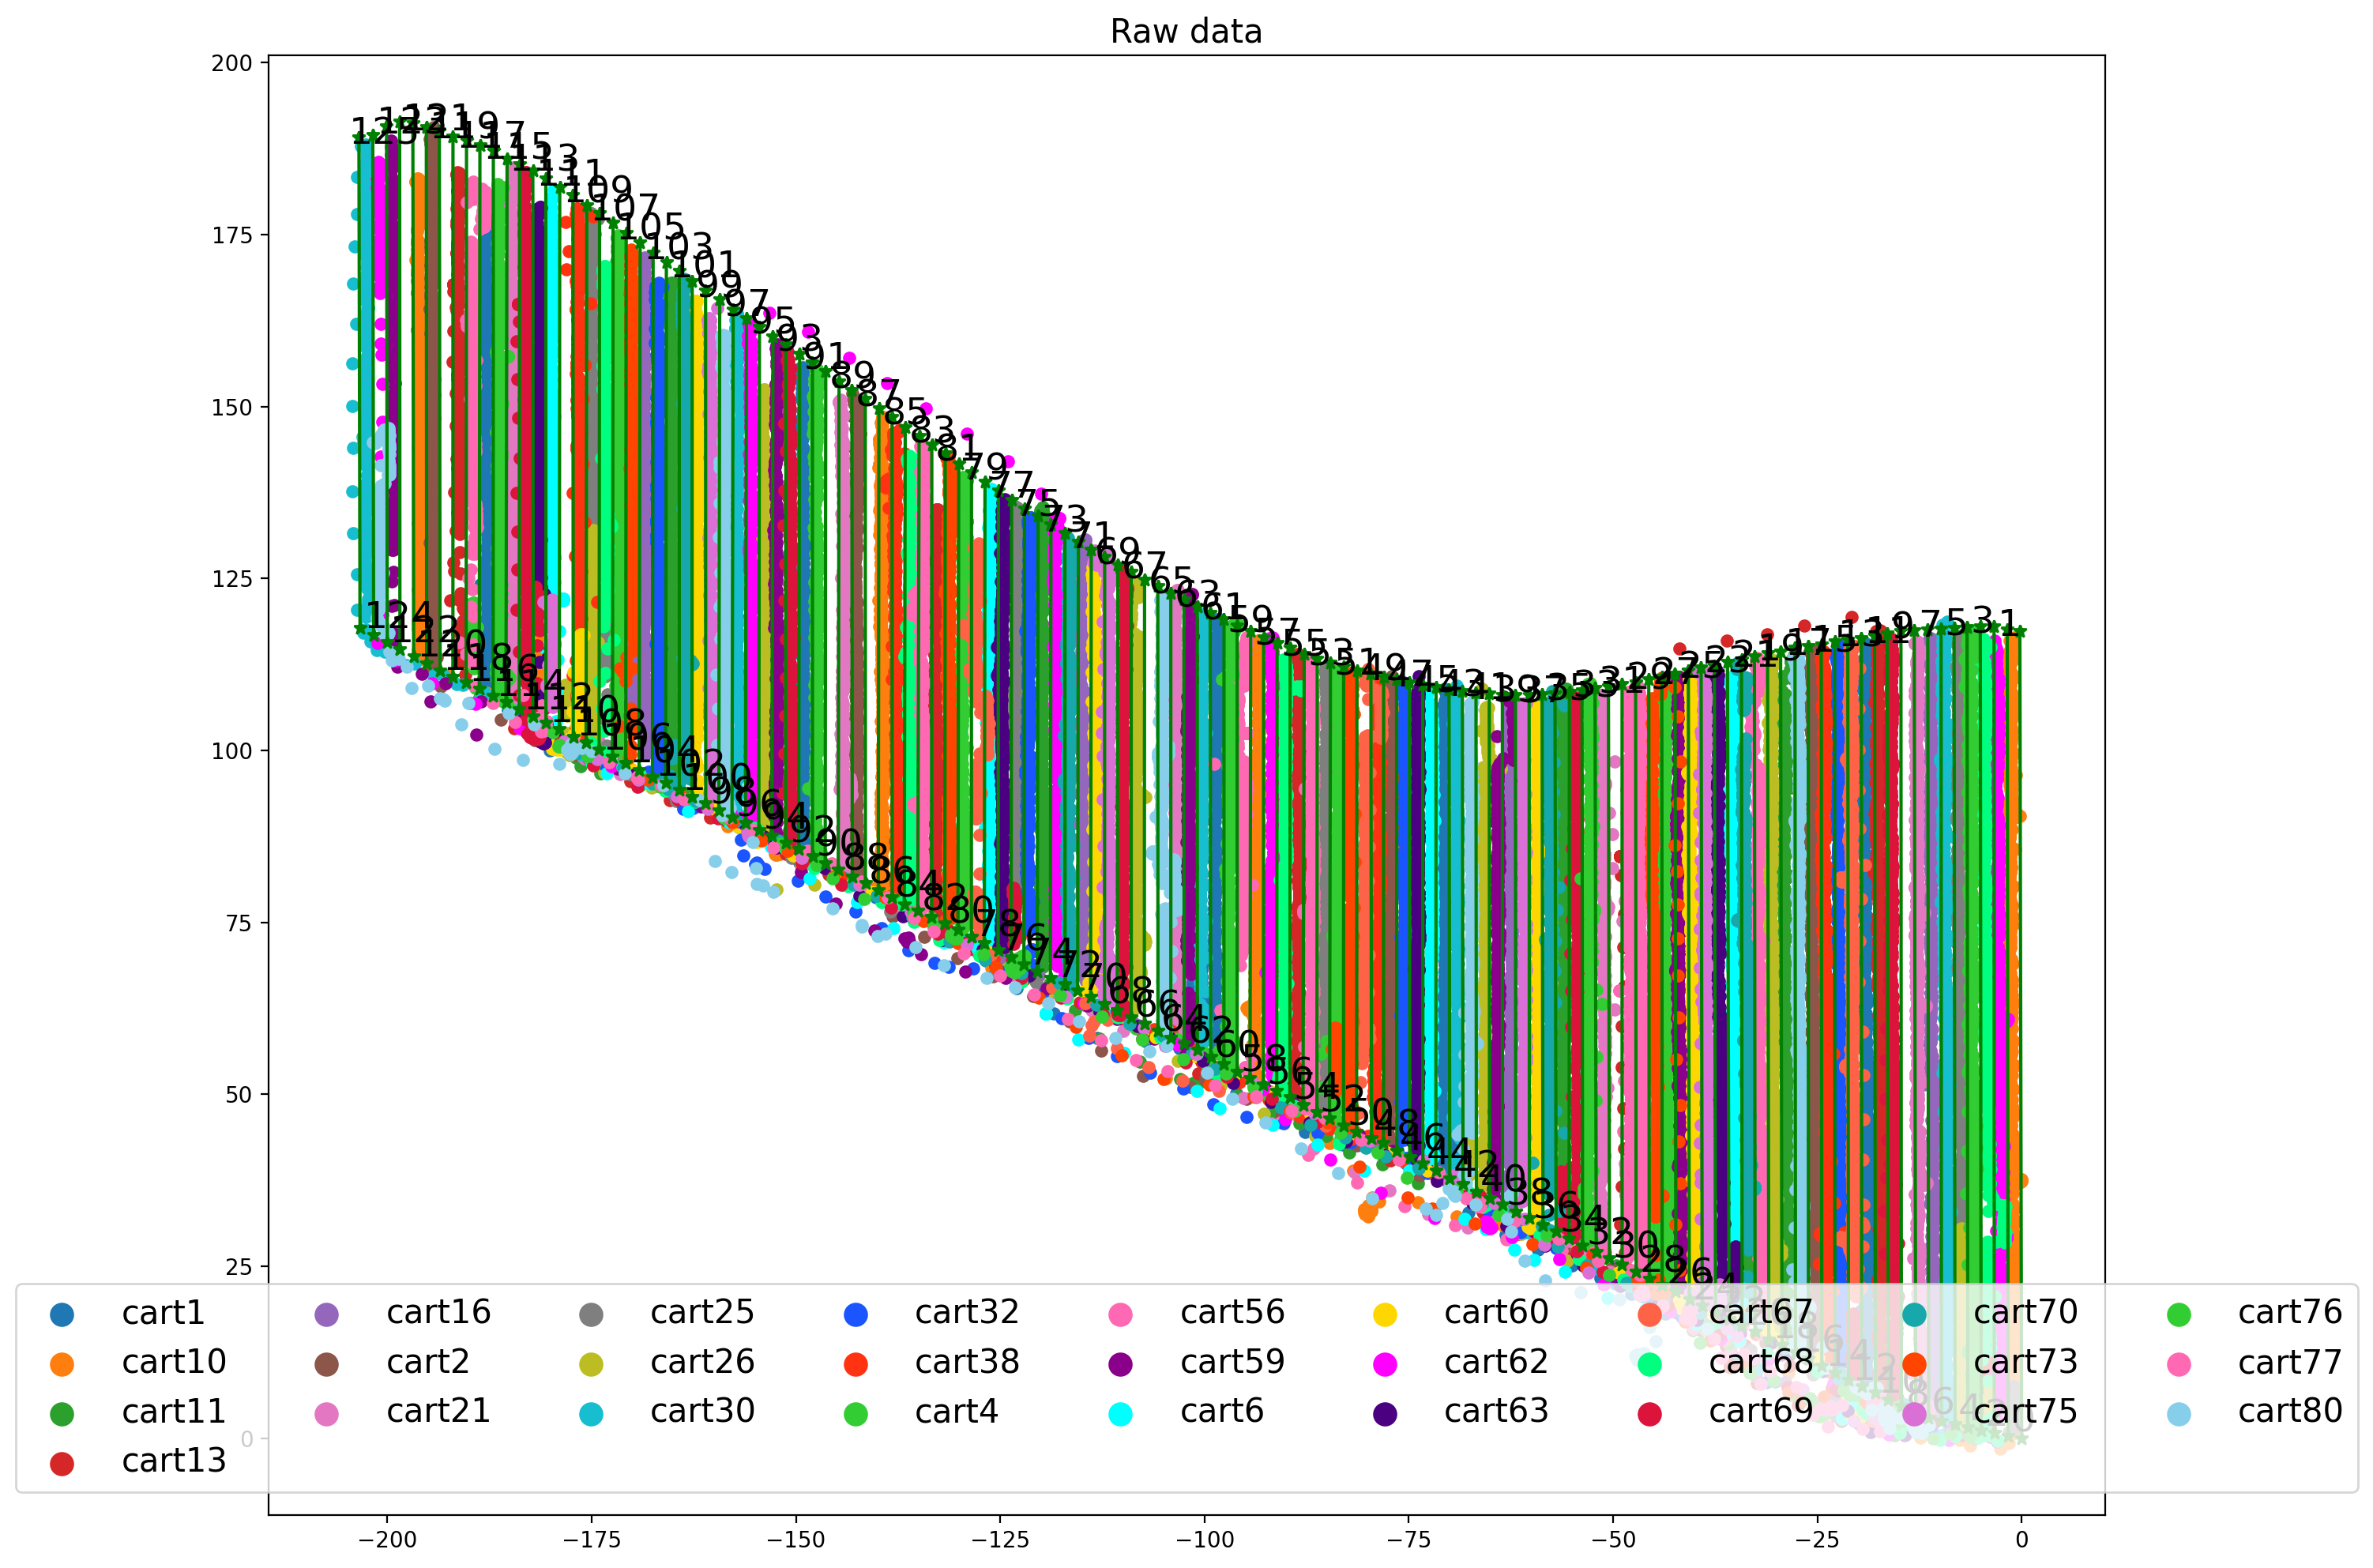

In [9]:

plt.figure(figsize=(15, 12))
plot_beds()
index=0
dn=50
for cart in raw_field_data.keys():
    N = len(raw_field_data[cart])
    cart_data= raw_field_data[cart]
    plt.scatter(cart_data[0:N:dn, -2], cart_data[0:N:dn, -1], s=25, c=colors[index%len(colors)], label=cart)
    index=index+1
plt.legend(fontsize=15, loc='lower center', bbox_to_anchor=(0.5, 0.004), ncol=len(raw_field_data.keys())//3,markerscale=2)

plt.title("Raw data",fontsize=15)

### <span style="color:white; font-weight:bold;">1.1: Identify picking data and non-picking data using CNN-LSTM</span>

In [10]:
# data header: "GPS_TOW LAT LON HEIGHT ax ay az raw_mass easting northing x y"
filtered_data_cnn={}


for cart_id in raw_field_data.keys():
    cart_data=raw_field_data[cart_id]
    X_test=data_filter.prepare_test(cart_data)
    y_pred=data_filter.run_model(X_test,model_path)
    y_pred1 = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], 1, y_pred.shape[2])
    y_pred1 = np.repeat(y_pred1, 100, axis=2).reshape(y_pred.shape[0], y_pred.shape[1] * 100, y_pred.shape[2])
    y_pred1 = y_pred1.reshape(-1, 2)[:,1] #0 NoPick 1 Pick
    y_pred1 = np.where(y_pred1 >= 0.5, 1, 0) # 0 NoPick 1 Pick
    cart_data = np.column_stack((cart_data, y_pred1[:len(cart_data)]))
    filtered_data_cnn[cart_id]=cart_data

2025-07-14 15:13:48.416759: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-07-14 15:13:48.416782: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: uddhavXPS
2025-07-14 15:13:48.416786: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: uddhavXPS
2025-07-14 15:13:48.416938: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 550.144.3
2025-07-14 15:13:48.416954: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 550.144.3
2025-07-14 15:13:48.416956: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 550.144.3



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Text(0.5, 1.0, 'CNN and boundary filtered data')

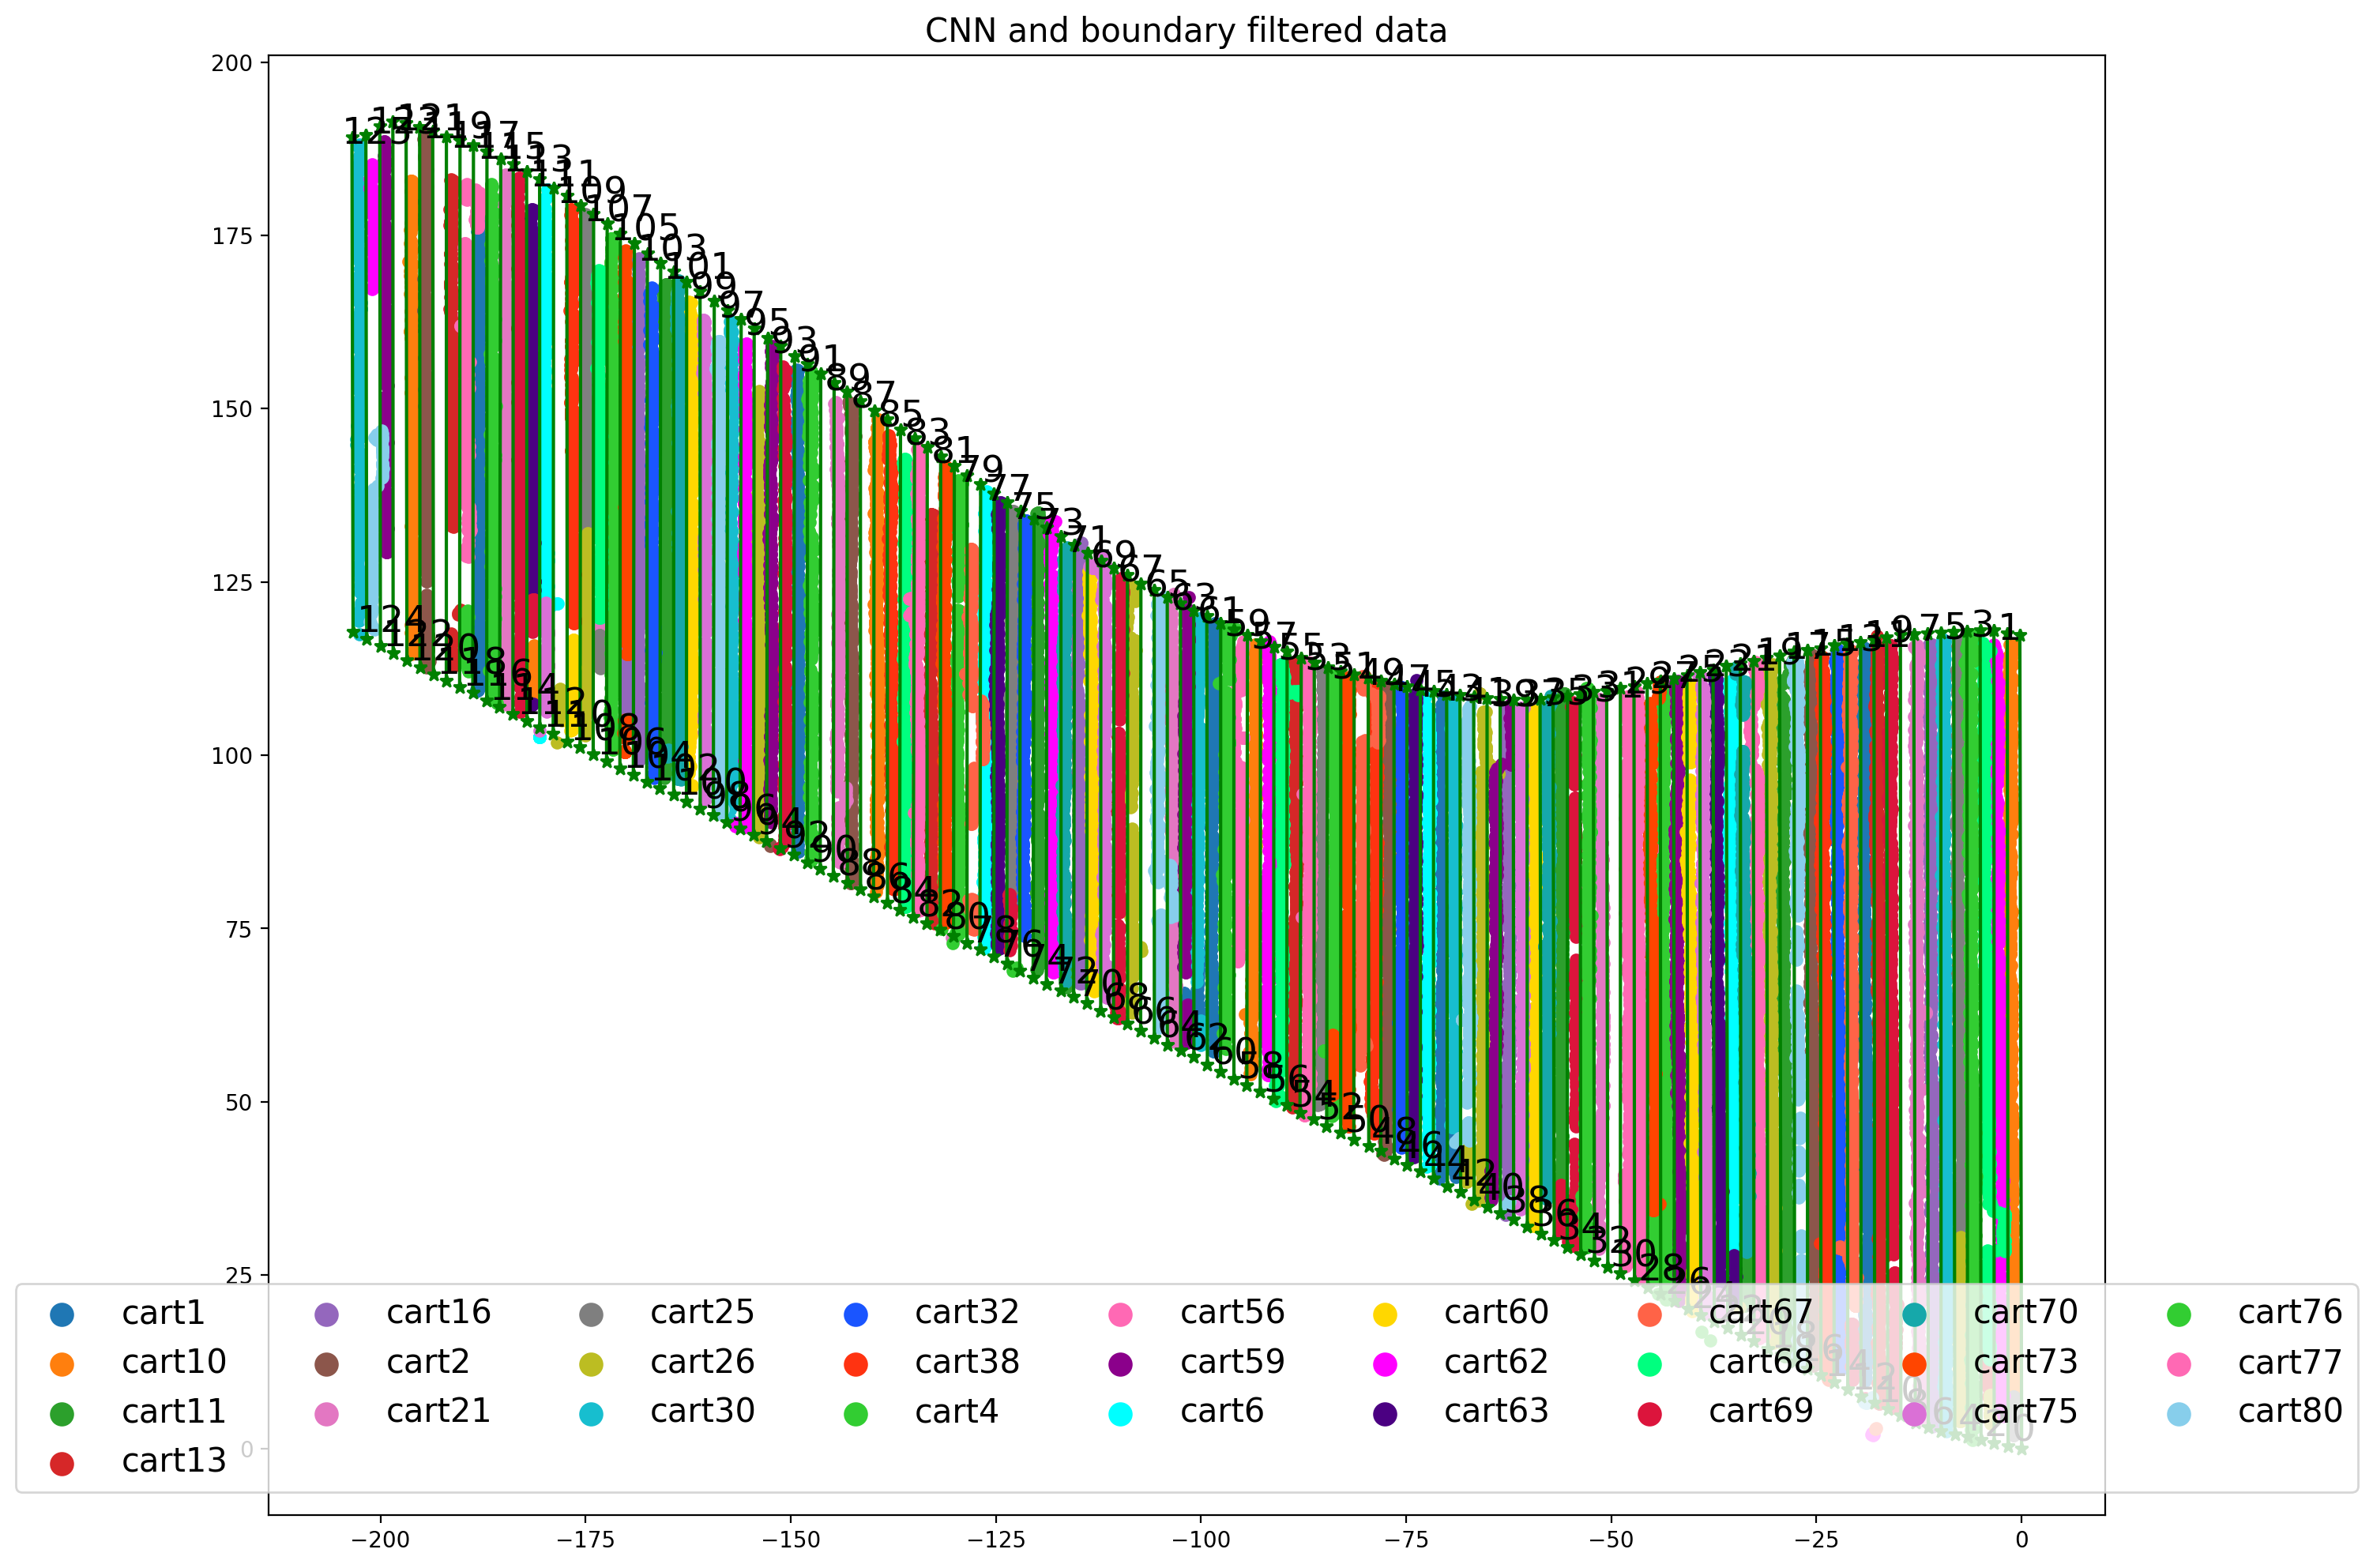

In [11]:
plt.figure(figsize=(15, 12))
plot_beds()
index=0
dn=50
for cart in filtered_data_cnn.keys():
    N = len(filtered_data_cnn[cart])
    cart_data= filtered_data_cnn[cart]
    cart_data_filtered = cart_data[cart_data[:, -1] == 1]
    plt.scatter(cart_data_filtered[0:N:dn, -3], cart_data_filtered[0:N:dn, -2], s=25, c=colors[index%len(colors)], label=cart)
    index=index+1
plt.legend(fontsize=15, loc='lower center', bbox_to_anchor=(0.5, 0.004), ncol=len(filtered_data_cnn.keys())//3,markerscale=2)

plt.title("CNN and boundary filtered data",fontsize=15)

In [12]:
# from utils.dataFiltering import data_filter
picking_area = data_filter.get_pick_area_santamaria_24(odom_NDs, odom_FDs, tolerance_x=1, tolerance_y=0)
filtered_data_picking=data_filter.identify_range_outliers_raw(filtered_data_cnn,picking_area)


(43, 2)


Text(0.5, 1.0, 'CNN and boundary filtered data')

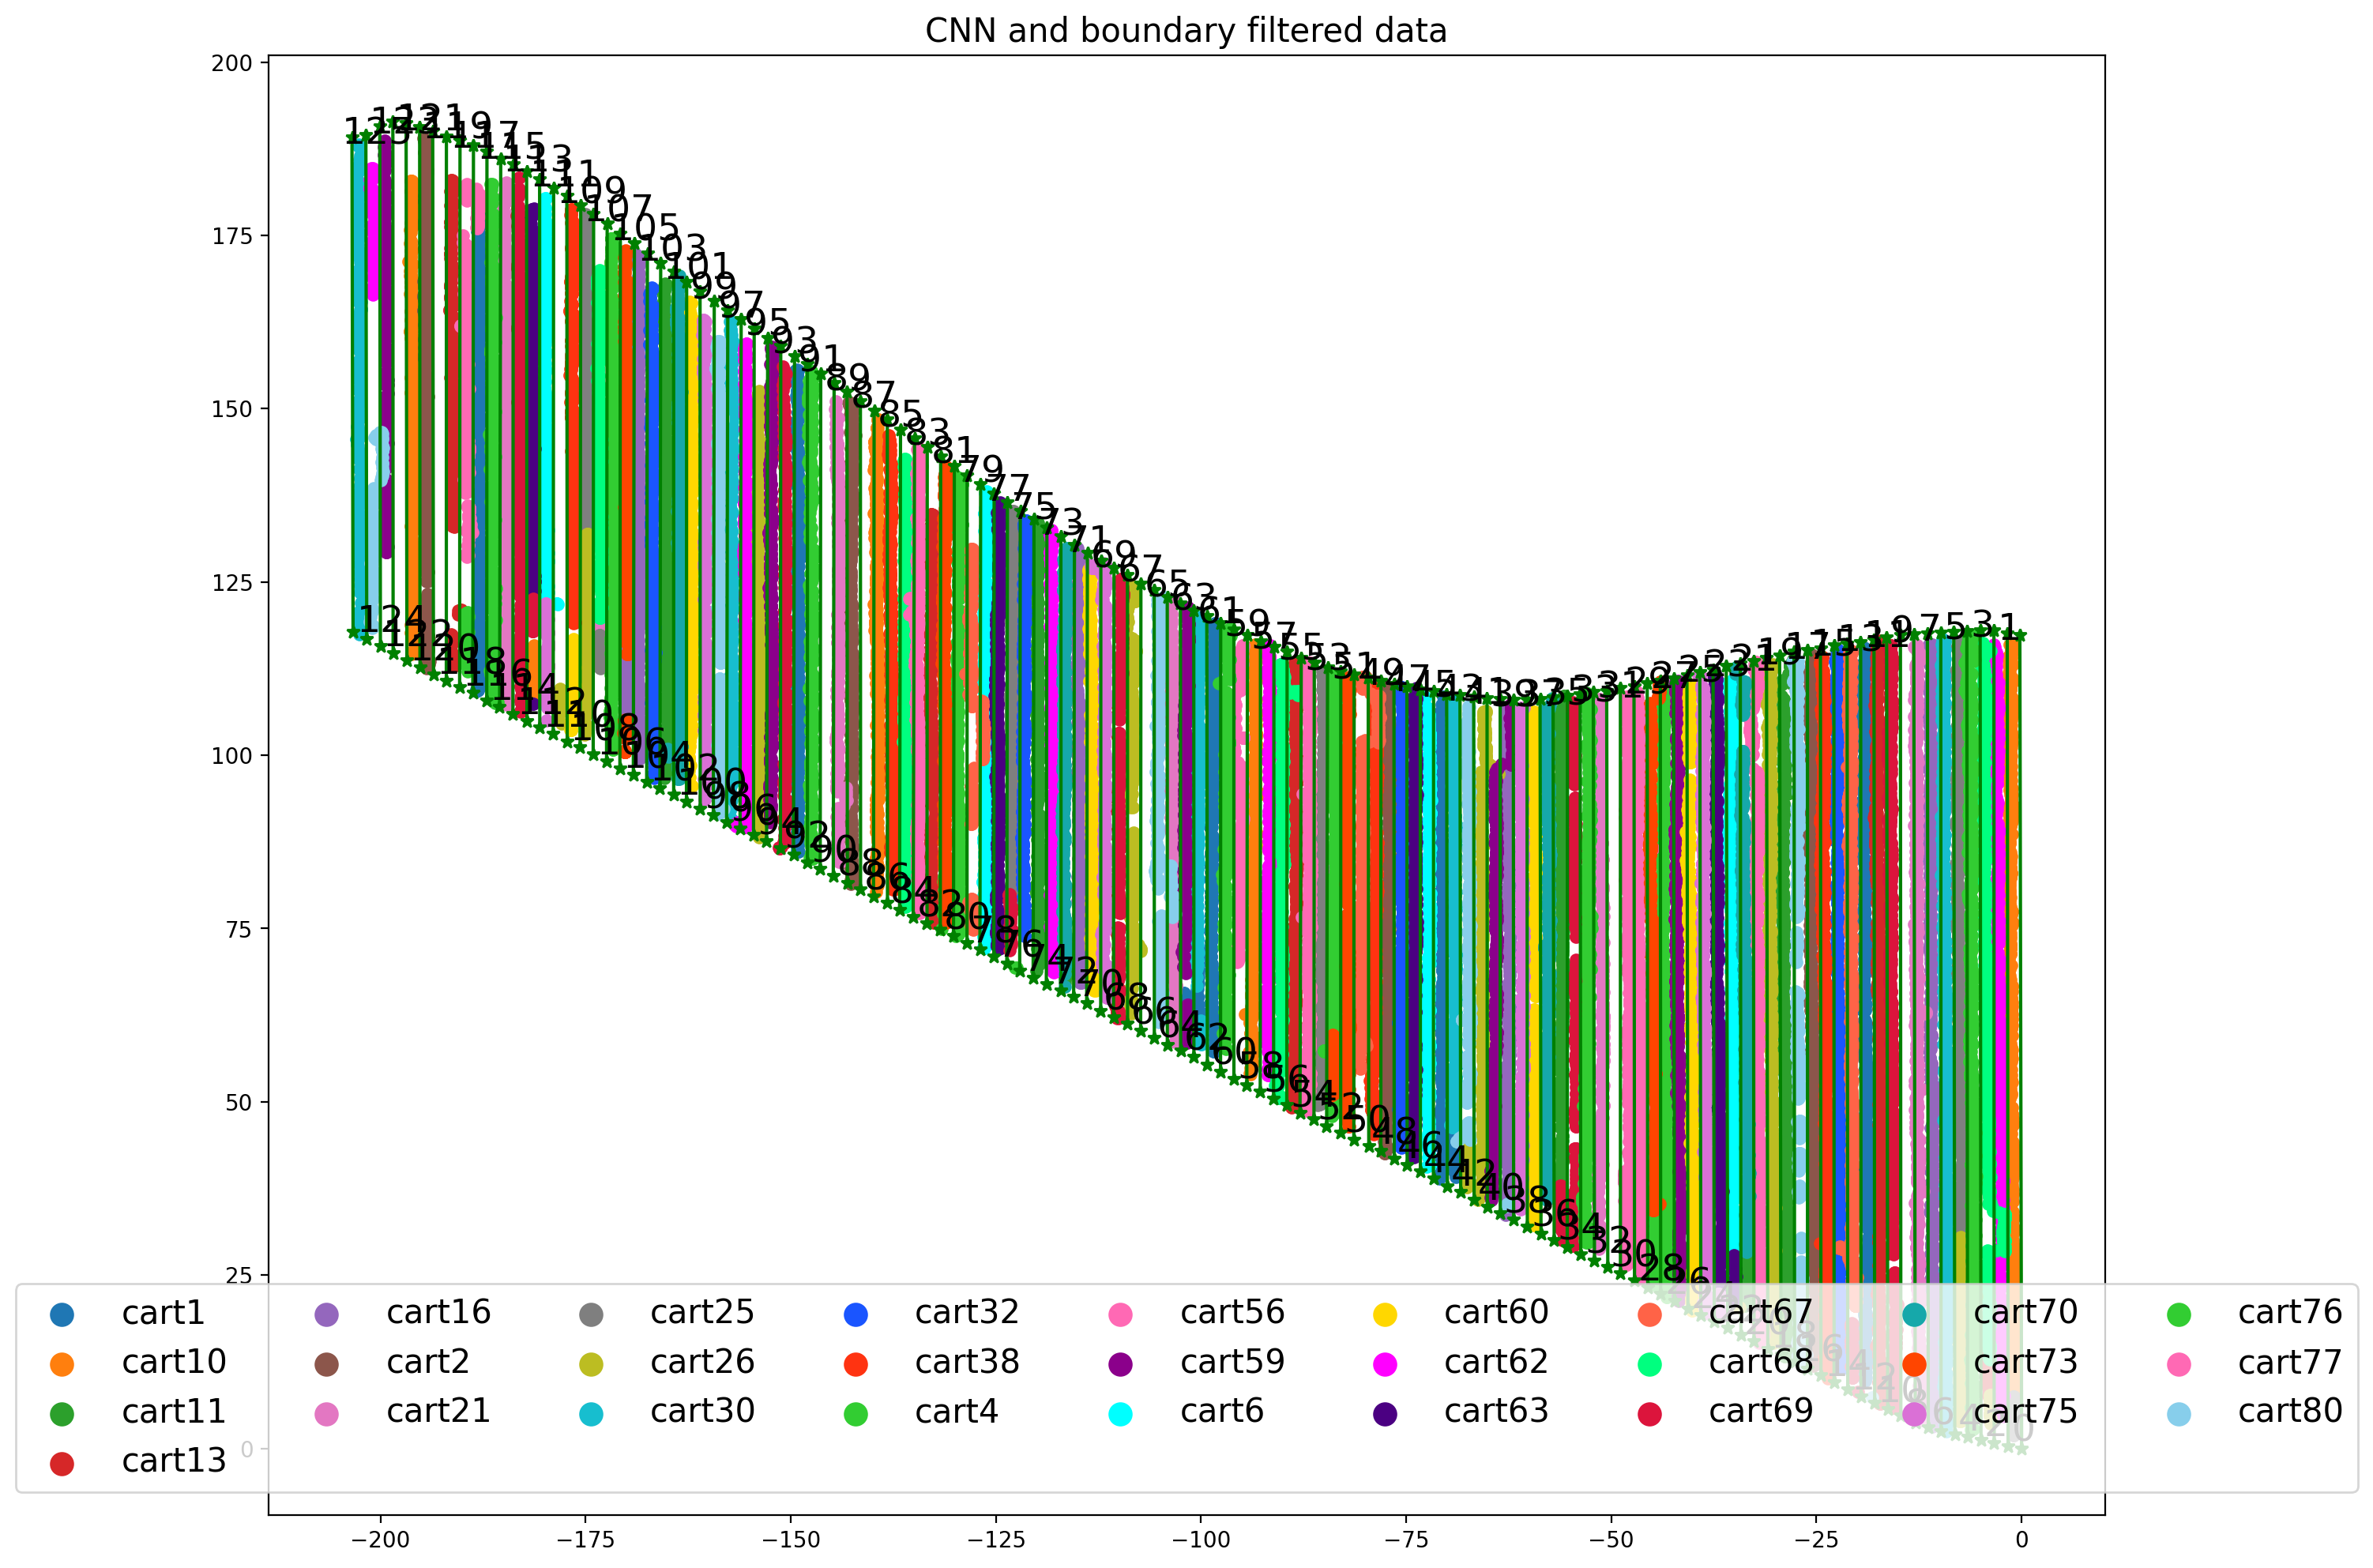

In [13]:
plt.figure(figsize=(15, 12))
plot_beds()
index=0
dn=50
for cart in filtered_data_picking.keys():
    N = len(filtered_data_picking[cart])
    cart_data= filtered_data_picking[cart]
    cart_data_filtered = cart_data[cart_data[:, -1] == 1]
    plt.scatter(cart_data_filtered[0:N:dn, -3], cart_data_filtered[0:N:dn, -2], s=25, c=colors[index%len(colors)], label=cart)
    index=index+1
plt.legend(fontsize=15, loc='lower center', bbox_to_anchor=(0.5, 0.004), ncol=len(filtered_data_picking.keys())//3,markerscale=2)

plt.title("CNN and boundary filtered data",fontsize=15)

In [14]:
pick_no_pick_dataframe = {
    'harvest_date': [],
    'cart_id': [],
    'stamps': [],
    'raw_mass': [],
    'pred_status': []
}

for cart_id in filtered_data_picking.keys():
    cart_no = int(cart_id[4:])
    cart_no_arr = np.full(np.shape(filtered_data_picking[cart_id])[0], cart_no)
    date_arr = np.full(np.shape(filtered_data_picking[cart_id])[0], date_time)

    pick_no_pick_dataframe['harvest_date'].extend(date_arr.tolist())  
    pick_no_pick_dataframe['stamps'].extend(filtered_data_picking[cart_id][:, 0].tolist())  
    pick_no_pick_dataframe['cart_id'].extend(cart_no_arr.tolist())  
    pick_no_pick_dataframe['raw_mass'].extend(filtered_data_picking[cart_id][:, 7].tolist())  
    pick_no_pick_dataframe['pred_status'].extend(filtered_data_picking[cart_id][:, -1].tolist())


In [15]:
pick_no_pick_dataframe
df = pd.DataFrame(pick_no_pick_dataframe)

Saving the results for individual harvest days

In [ ]:
destination_dir = os.path.join(root_dir,"results",field,"class_results")
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)
df.to_csv(os.path.join(destination_dir,date_time+"_class_results.csv"),index=False)

End of "Pick" and "NoPick" classification for season-long data.